In [1]:
# Importing modules
import warnings

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS

from statsmodels.api import add_constant
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
warnings.simplefilter(action='ignore')

In [ ]:
# testassets = pd.read_csv("100_Portfolios_10x10_Daily_EW.csv", parse_dates=['Date']) # dim = (99597, 101)
# ## (b) Replace -99.99 and -999 in the data with NA, i.e., the data point
# ##     for that date is not available.


# for column in testassets.columns:
#     testassets.loc[testassets[column] == -99.99,[column]] = np.nan
#     testassets.loc[testassets[column] == -999,[column]] = np.nan
    
# testassets.head()

In [71]:
# importing Monthly data

testassets = pd.read_csv("testassets2022-23-exam.csv", parse_dates = ['month']).drop(columns = 'Unnamed: 0')# droping the index written in the file
factors = pd.read_csv("factors2022-23-exam.csv",  parse_dates = ['month']).drop(columns = 'Unnamed: 0')# droping the index written in the file


print("test assets shape: ",testassets.shape)
print("Factors shape: ",factors.shape)
## testassets = 1156 monthly observations of 26 test assets
## factors = 712 monthly observations of 7 factors

test assets shape:  (1156, 26)
Factors shape:  (712, 7)


In [72]:
## by default pandas assumes that observations are recorded in the beginning of each month since date only contains month and years.
## Returns for a month are calculated at the end of each month, manually adding the last day of each month in the date.
def change_date_end(date):
    Date = pd.to_datetime(date, format="%Y%m") + pd.tseries.offsets.MonthEnd(0)
    return Date

In [73]:
## converting the data sets to time series

testassets.month = testassets.month.apply(change_date_end)
factors.month = factors.month.apply(change_date_end)

In [74]:
testassets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       1156 non-null   datetime64[ns]
 1   SMALL LoBM  1156 non-null   float64       
 2   ME1 BM2     1156 non-null   float64       
 3   ME1 BM3     1156 non-null   float64       
 4   ME1 BM4     1156 non-null   float64       
 5   SMALL HiBM  1156 non-null   float64       
 6   ME2 BM1     1156 non-null   float64       
 7   ME2 BM2     1156 non-null   float64       
 8   ME2 BM3     1156 non-null   float64       
 9   ME2 BM4     1156 non-null   float64       
 10  ME2 BM5     1156 non-null   float64       
 11  ME3 BM1     1156 non-null   float64       
 12  ME3 BM2     1156 non-null   float64       
 13  ME3 BM3     1156 non-null   float64       
 14  ME3 BM4     1156 non-null   float64       
 15  ME3 BM5     1156 non-null   float64       
 16  ME4 BM1     1156 non-nul

In [75]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   month   712 non-null    datetime64[ns]
 1   Mkt-RF  712 non-null    float64       
 2   SMB     712 non-null    float64       
 3   HML     712 non-null    float64       
 4   RMW     712 non-null    float64       
 5   CMA     712 non-null    float64       
 6   RF      712 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 39.1 KB


# Average monthly returns on these portfolios over the sample period 1963:07 to 2021:10

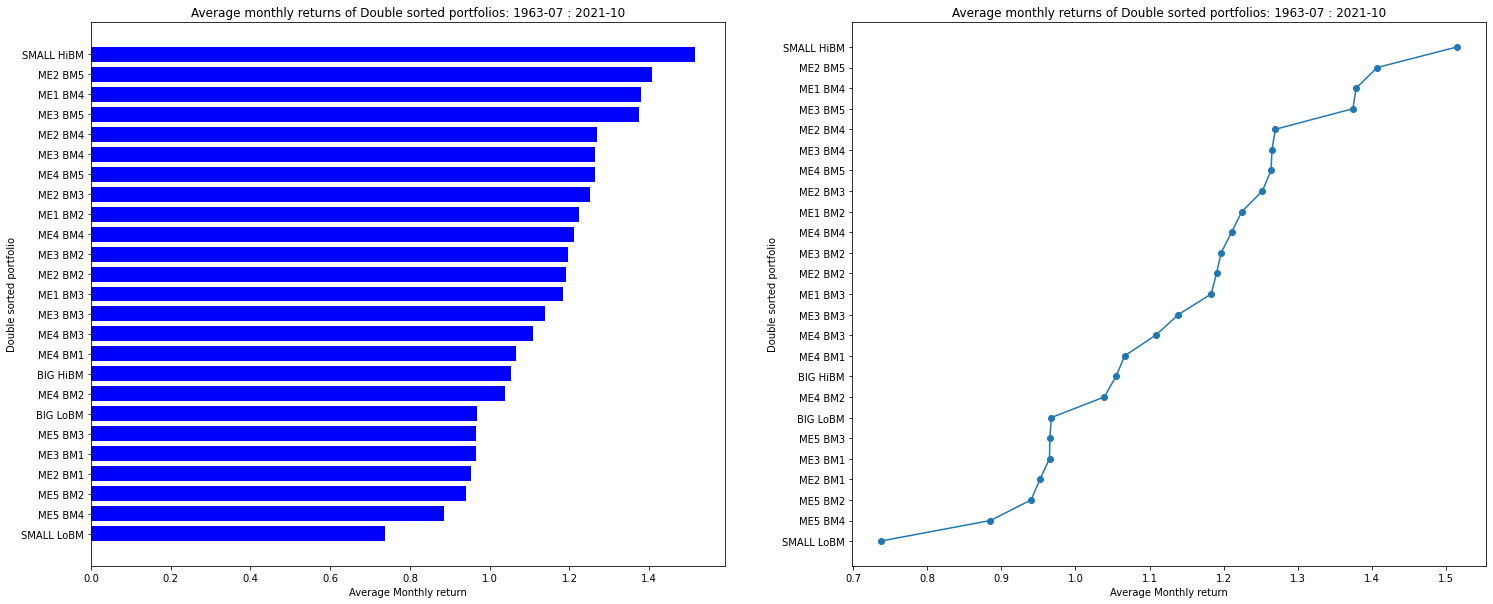

In [76]:
## subsetting testassets to only keep sample period and taking portfolio wise average

testassets_sampleA = testassets.set_index('month')['1963-07-31': '2021-10-31'] ## including both ends.
average_returns = testassets_sampleA.mean() ## column wise mean of the portfolio returns

## Sorting and plotting the underlying
average_returns_sorted = average_returns.sort_values()
fig, ax = plt.subplots(1,2,figsize = (25,10))    
width = 0.75 
ax[0].barh(average_returns_sorted.index,average_returns_sorted.values, width, color="blue")
ax[0].set_yticklabels(average_returns_sorted.index)

ax[0].set_title('Average monthly returns of Double sorted portfolios: 1963-07 : 2021-10')
ax[0].set_xlabel('Average Monthly return')
ax[0].set_ylabel('Double sorted portfolio')

ax[1].set_title('Average monthly returns of Double sorted portfolios: 1963-07 : 2021-10')
ax[1].set_xlabel('Average Monthly return')
ax[1].set_ylabel('Double sorted portfolio')

ax[1].scatter(average_returns_sorted.values,average_returns_sorted.index)
ax[1].plot(average_returns_sorted.values,average_returns_sorted.index)

plt.show()

## Creating a double sorted table

In [118]:
bm_s = []
for index in average_returns_sorted.index:
    bm_s.append(index.split(' ')[1])
bm_s = pd.Series(bm_s).unique()
bm_s.sort()

In [119]:
# sorting bm_s in order from lobm to hibm
for j in range(len(bm_s)-1):
    for i in range(1,len(bm_s)):
        temp = bm_s[i]
        bm_s[i] = bm_s[i-1]
        bm_s[i-1] = temp  
bm_s

array(['LoBM', 'BM1', 'BM2', 'BM3', 'BM4', 'BM5', 'HiBM'], dtype=object)

In [120]:
bm_dict = {}
 
for bm in bm_s:
    me_s = []
    bm_dict[bm] = average_returns[average_returns.index.str.contains(bm)]
    for j in bm_dict[bm].index:
        me_s.append(j.split(' ') [0])
    bm_dict[bm].index = me_s

sorted_df = pd.DataFrame()
for key, value in bm_dict.items():
    value = pd.DataFrame(value, columns=[key])
    sorted_df= pd.merge(sorted_df, value, left_index=True, how = 'outer', right_index=True)

In [125]:
## swaping first and last row for symmetry such that index go from small -> Big Market 
## swaping 
sorted_df
df_1 = sorted_df.copy()
temp = df_1.iloc[0,].copy()
df_1.iloc[0,] = df_1.iloc[-1,].copy()
df_1.iloc[-1,] = temp.copy()
df_1. index = ['SMALL', 'ME1', 'ME2', 'ME3', 'ME4', 'ME5','BIG' ]
df_1.fillna(-100)


,LoBM,BM1,BM2,BM3,BM4,BM5,HiBM
SMALL,0.737472,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,1.514621
ME1,-100.000000,-100.000000,1.224345,1.183028,1.378470,-100.000000,-100.000000
ME2,-100.000000,0.952185,1.190246,1.251993,1.269609,1.406999,-100.000000
ME3,-100.000000,0.965115,1.196456,1.138853,1.264988,1.374137,-100.000000
ME4,-100.000000,1.066481,1.039073,1.108275,1.210585,1.263781,-100.000000
ME5,-100.000000,-100.000000,0.940278,0.965546,0.885503,-100.000000,-100.000000
BIG,0.967593,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,1.054700


In [193]:
## NOTE_: The table shown above is exhaustive of 25 portfolios in the dataset 'testassets2022-23-exam.csv'.
## The provided Dataset does not have portfolios with -100 values in the table. ex: ME1 LoBM or SMALL BM1 do not exist in the dataset
## Nan values are introduced due to tabular representation of the sorted results results based on Fama french size and value factors.
# Nans have been replaced by -100.

In [127]:
# BROAD PATTERNS observed:
#  Keeping B/M constant, with increase in size (mooving downwards in each column), the average monthly retuns decrease (Except for BM1)
#  Keeping size constant, with increase in B/M (mooving left to right in each Row), the average monthly retuns Increase (Except for ME5)
#  Equities of Small sized, high Value Firms outperform their bigger and/or low value counterperts (Top right corner is greater than all other.)

# Average volatility in asset returns

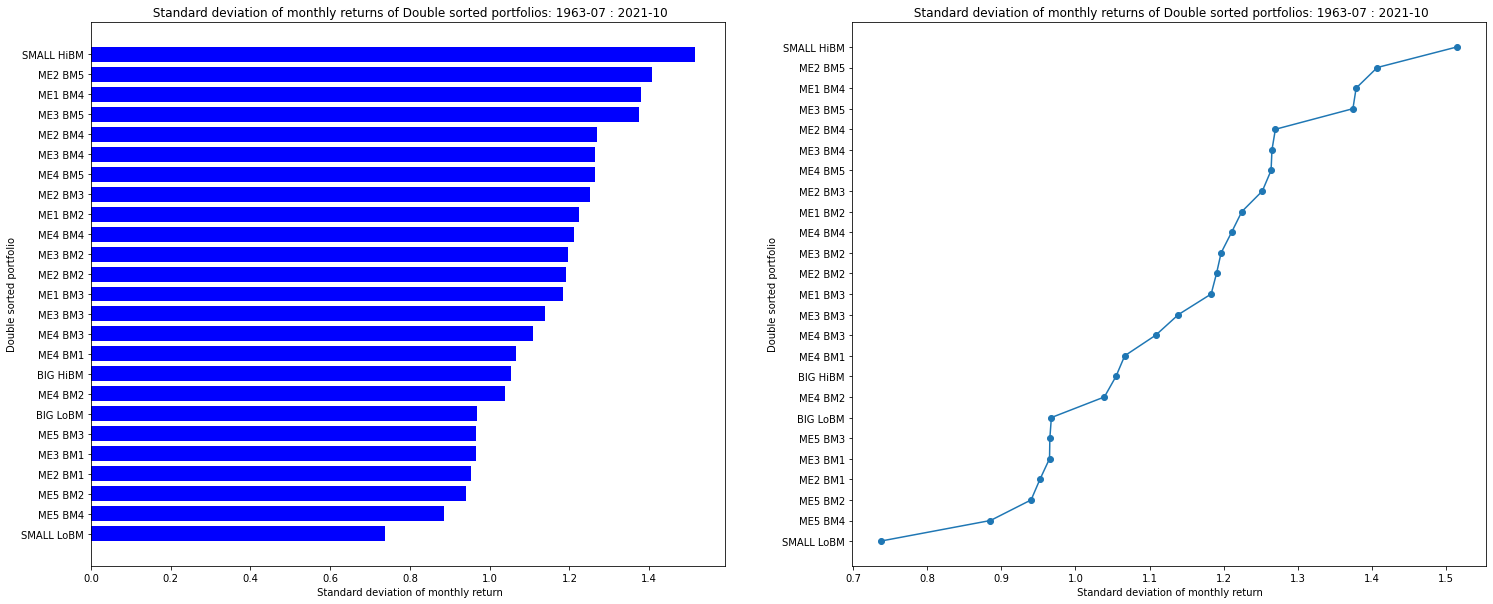

In [128]:
std_returns = testassets_sampleA.std()

std_returns_sorted = average_returns.sort_values()

fig, ax = plt.subplots(1,2,figsize = (25,10))    
width = 0.75 
ax[0].barh(std_returns_sorted.index,std_returns_sorted.values, width, color="blue")
ax[0].set_yticklabels(std_returns_sorted.index, minor=False)

ax[0].set_title(' Standard deviation of monthly returns of Double sorted portfolios: 1963-07 : 2021-10')
ax[0].set_xlabel(' Standard deviation of monthly return')
ax[0].set_ylabel('Double sorted portfolio')


ax[1].scatter(std_returns_sorted.values,std_returns_sorted.index)
ax[1].plot(std_returns_sorted.values,std_returns_sorted.index)

ax[1].set_title(' Standard deviation of monthly returns of Double sorted portfolios: 1963-07 : 2021-10')
ax[1].set_xlabel(' Standard deviation of monthly return')
ax[1].set_ylabel('Double sorted portfolio')

plt.show()


# 5 factor Famma-Mcbeth regression (stationary / non-rolling) for infrence with GRS score 

In [142]:
## function to calculate the GRS test statistic
def grs(alphas, resids,T, N, K,factors):

    # T <- No.of observations
    # N <- No.of Testassets/portfolios
    # K <- No.of factors
    alphas = np.matrix(alphas)
    # Sigma <- var-covariance matrix of residuals
    sigma = np.matrix(resids.cov())
    sigma_inverse = np.linalg.inv(sigma)
    # demeaned <- factors - Expected value
    demeaned = factors - factors.mean() 
    # Omega <- (t(demeaned)%*%demeaned)/T
    omega = np.matmul(np.transpose(demeaned), demeaned)/T
    f = factors.mean().values
    # GRS <- ((T-N-K)/N)*solve(1+t(f)%*%solve(Omega)%*%f)*t(alphas)%*%solve(Sigma)%*%alphas
    a = ((T-N-K)/N)
    # b = solve(1+t(f)%*%solve(Omega)%*%f)
    b = np.linalg.inv(np.matrix(1 + np.matmul(np.matmul(np.transpose(f), np.linalg.inv(omega)), f)))
    # c = t(alphas)%*%solve(Sigma)%*%alphas
    c = np.matmul(np.matmul(alphas, sigma_inverse), alphas.T)
    GRS = a*b*c
    print('The GRS test statistic is:', float(GRS))

## step 1: Time series regressions -> estimating 5 factor beetas (loadings) for 25 test portfolios excess returns

In [129]:
factors.set_index('month', inplace = True)
## creating a df with five factors b/w 1960/07 and 2020/10
five_factor = factors['1963-07-31': '2021-10-31']
five_factor.drop(columns=['RF'], inplace = True)
five_factor.head()

,Mkt-RF,SMB,HML,RMW,CMA
month,,,,,
1963-07-31,-0.39,-0.41,-0.97,0.68,-1.18
1963-08-31,5.07,-0.80,1.80,0.36,-0.35
1963-09-30,-1.57,-0.52,0.13,-0.71,0.29
1963-10-31,2.53,-1.39,-0.10,2.80,-2.01
1963-11-30,-0.85,-0.88,1.75,-0.51,2.24


In [130]:
testassets_sampleA_excess_return= pd.merge(testassets_sampleA, factors['RF'], left_index=True,right_index=True)
## calculating excess returns: testassets_return - factors_RF
for column in testassets_sampleA_excess_return.columns:
    testassets_sampleA_excess_return.loc[:,column] = testassets_sampleA_excess_return.loc[:,column] - testassets_sampleA_excess_return.loc[:,'RF']
testassets_sampleA_excess_return.drop(columns=['RF'], inplace = True)  

In [143]:
## setting up a dataframe for 5 factor beetas.

portfolio = []
alpha_5 = []
Mkt_B = []
Smb_B = []
Hml_B = []
Rmw_b =[]
Cma_b = []
resids_5 = pd.DataFrame(columns = testassets_sampleA_excess_return.columns, index = testassets_sampleA_excess_return.index)

for column in testassets_sampleA_excess_return.columns :
    analsiss_df =  pd.merge(testassets_sampleA_excess_return[column], five_factor, left_index=True,right_index=True)
    ## analysis_df = excess retruns of a given testasstets vs 5 factor observations 
    y = analsiss_df[column]
    X = analsiss_df[five_factor.columns]
    X = add_constant(X)

    model = OLS(y, X).fit()
    ## capturing asset name
    portfolio.append(column)
    ## capturing slope and intercept
    alpha_5.append(model.params['const'])
    Mkt_B.append(model.params['Mkt-RF']) ## estimated factor loading of the excess asset returns on the excess market returns
    Smb_B.append(model.params['SMB']) ## estimated factor loading of the excess asset returns on the 'SMB' factor
    Hml_B.append(model.params['HML'])
    Rmw_b.append(model.params['RMW'])
    Cma_b.append(model.params['CMA'])
    resids_5[column] = model.resid
five_ts_regression_beeta = pd.DataFrame({'portfolio' : portfolio,'Mkt': Mkt_B, 'Smb' : Smb_B, 'Hml': Hml_B, 'Rmw':Rmw_b, 'Cma': Cma_b}).set_index('portfolio')
grs(alphas= np.array(alpha_5),resids = resids_5, T = 700,N = 25, K = 5, factors = five_factor)## calulating GRS statistic


The GRS test statistic is: 3.029379801096847


In [149]:
five_ts_regression_beeta.shape ## 5 factor loadings for each of 25 testassets

(25, 5)

In [146]:
five_ts_regression_beeta.head()

,Mkt,Smb,Hml,Rmw,Cma
portfolio,,,,,
SMALL LoBM,1.052240,1.271015,-0.413917,-0.500538,-0.124078
ME1 BM2,0.937359,1.217539,-0.171838,-0.391764,0.015149
ME1 BM3,0.924713,1.073808,0.121238,-0.061380,0.037270
ME1 BM4,0.883463,1.066499,0.291813,-0.041190,0.055835
SMALL HiBM,0.973775,1.095315,0.409569,0.020657,0.270553


## Step 2: cross sectional regressions to estimate factor-premia (Lambda)

On average how much does the market award us to hold on to the risk associated with these factors

In [156]:
## Estimating risk premia for all portfolios with 5 factors
lambda_ = []
tvals_ = []
for index in testassets_sampleA_excess_return.index:
    ## merging excess returns at time t with estimated beeta values for three factor models. for t belong to ['1963-07', '2021-10']
    analsiss_df = pd.merge(testassets_sampleA_excess_return.loc[index,: ],five_ts_regression_beeta, left_index= True, right_index=True)
    analsiss_df.columns = ['excess_returns', 'Mkt', 'Smb', 'Hml', 'Rmw', 'Cma'] # renaming columns for better readability
    X =  analsiss_df[['Mkt', 'Smb', 'Hml', 'Rmw', 'Cma']] # Independant variables
    y =  analsiss_df['excess_returns'] # Dependant variables
    # X = add_constant(X) # adding a constant (Intercept); the riskfree rate estimation step; uncomment to estimate what was the said riskfree rate
    model = OLS(y,X).fit()
    lambda_.append(model.params)
    tvals_.append(model.tvalues)
five_factor_lambdas_df = pd.DataFrame(lambda_,index= testassets_sampleA_excess_return.index)

In [157]:
five_factor_lambdas_df.head()

,Mkt,Smb,Hml,Rmw,Cma
month,,,,,
1963-07-31,-0.524741,-0.881517,-0.487694,-3.672978,3.827986
1963-08-31,5.110582,-1.087415,0.804387,1.804243,-2.832738
1963-09-30,-1.980208,-0.255464,0.453111,-1.112095,5.841119
1963-10-31,1.138598,0.618246,-0.404378,5.465121,-2.654036
1963-11-30,-1.231031,-0.905875,2.113085,1.405264,-0.204100


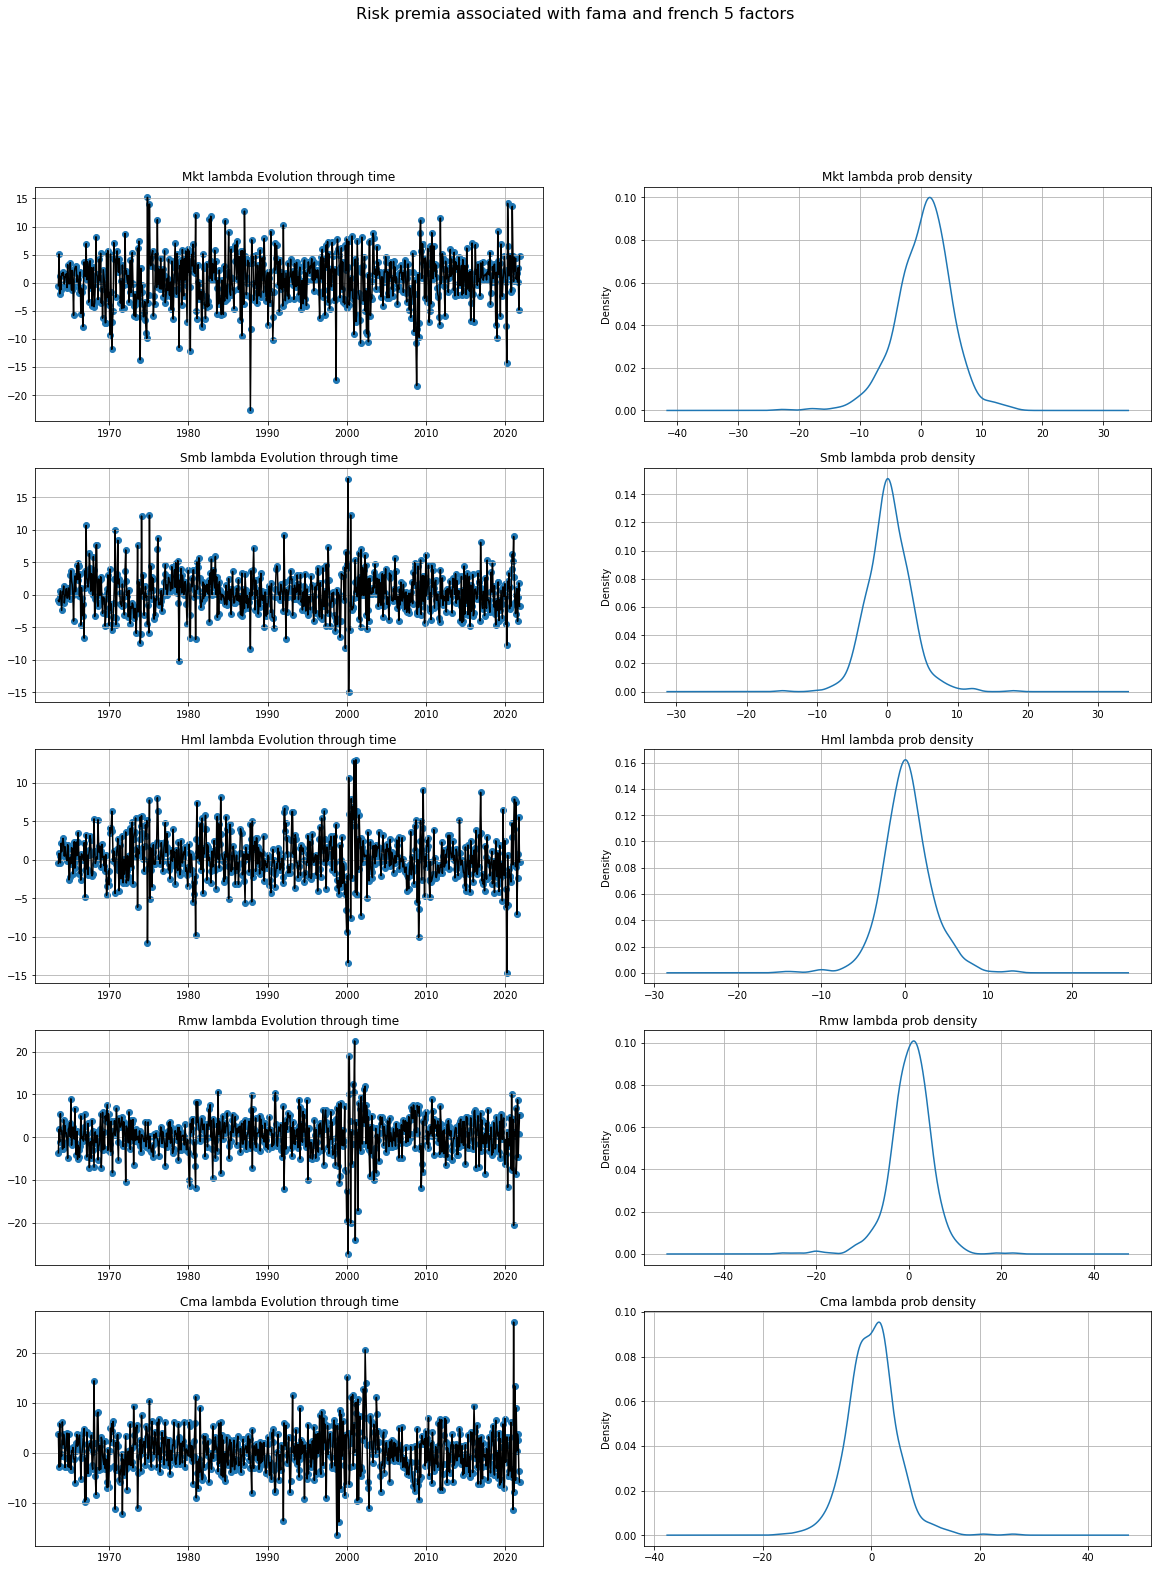

In [161]:
fig,ax = plt.subplots(5,2, figsize = (20,25)) # movements on the same scale.
fig.suptitle('Risk premia associated with fama and french 5 factors', fontsize = 16)
for i in range(0, len(five_factor_lambdas_df.columns)):
    ax[i,0].grid()
    ax[i,0].scatter(five_factor_lambdas_df.index,five_factor_lambdas_df[five_factor_lambdas_df.columns[i]])
    ax[i,0].plot(five_factor_lambdas_df.index,five_factor_lambdas_df[five_factor_lambdas_df.columns[i]], color = 'black')
    ax[i,0].set_title(five_factor_lambdas_df.columns[i] + ' lambda' + ' Evolution through time')
    ax[i,1].set_title(five_factor_lambdas_df.columns[i] + ' lambda' + ' prob density')
    sns.set_style({'axes.grid' : True})
    ax[i,1].grid()
    five_factor_lambdas_df[five_factor_lambdas_df.columns[i]].plot(kind='density', ax = ax[i,1])
plt.show()

We see that the market compensates holding risks associated with different factors differently through time.

We also notice that the distribution of some risk primeas are more heavily tailed than the others and ofcourse have differnt peaks.
 

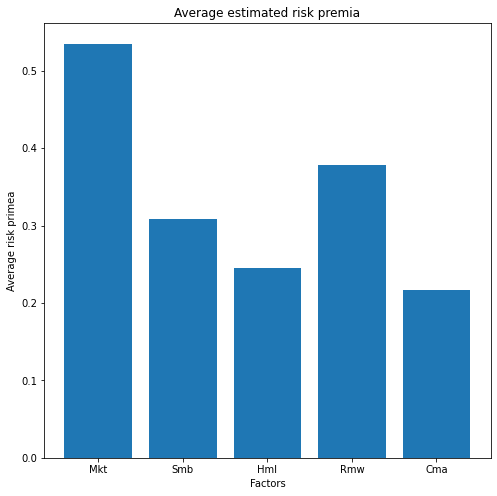

In [159]:
## on average how much did the market reward us for holding specific risks? 
# Average risk primea:
plt.figure(figsize = (8,8))
values = pd.DataFrame(five_factor_lambdas_df.mean())
plt.bar(five_factor_lambdas_df.mean().index,five_factor_lambdas_df.mean().values)
plt.title('Average estimated risk premia')
plt.ylabel('Average risk primea')
plt.xlabel('Factors')
plt.show()

# Fama-Mcbeth regressions (rolling) for predictions 


## STEP 1:  Rolling timeseries regressions:  Estimate 3-year rolling factor betas using the FF-three factor model as your Frst stage.

In [163]:
rolling_beeta_dfs = [] ## list of 25 dfs, each containing rolling 36 month beetas for each test portfolio. 
rolling_portfolio = []
for column in testassets_sampleA_excess_return.columns:
    analsiss_df = pd.merge(testassets_sampleA_excess_return[column], five_factor, left_index=True,right_index=True)
    # merging 1 portfolio return at a time with the factor time series using date
    endog = analsiss_df[column] # target variable
    exog = analsiss_df[five_factor.columns] # feature variables
    exog = add_constant(exog)
    rols = RollingOLS(endog, exog, window=36) # model with a window size of 36 months
    rres = rols.fit()
    params = rres.params.copy() # saving the estimated factor loadings for the model
    params.index = five_factor.index
    ## adding additional columns returns and name of the portfolio to make cross-regression (next step) easier
    params['excess_returns'] = testassets_sampleA_excess_return[column]

    params['portfolio'] = [column] * len(params.index) # saving the name of portfolio in the dataframe
    rolling_beeta_dfs.append(params.dropna())
    rolling_portfolio.append(column)

In [165]:
rolling_beeta_dfs[0]

,const,Mkt-RF,SMB,HML,RMW,CMA,excess_returns,portfolio
month,,,,,,,,
1966-06-30,-0.217359,1.045196,1.301237,-0.130495,0.071221,-0.123581,-1.1471,SMALL LoBM
1966-07-31,-0.273839,1.042950,1.311379,-0.109222,0.086096,-0.073256,-2.4888,SMALL LoBM
1966-08-31,-0.276490,1.035282,1.316126,-0.112486,0.086069,-0.069021,-12.6522,SMALL LoBM
1966-09-30,-0.223118,1.037390,1.306331,-0.148712,0.030029,-0.038953,-2.3653,SMALL LoBM
1966-10-31,-0.315564,0.959316,1.411517,-0.114324,0.185238,-0.075795,-8.4027,SMALL LoBM
...,...,...,...,...,...,...,...,...
2021-06-30,0.074236,1.112445,1.723726,-0.628365,-0.447943,0.476750,8.0810,SMALL LoBM
2021-07-31,0.071257,1.125985,1.695926,-0.600932,-0.559143,0.473798,-10.3981,SMALL LoBM
2021-08-31,0.162378,1.129756,1.687952,-0.594117,-0.581214,0.419405,2.8132,SMALL LoBM


## step 2: cross sectional predictive regression with estimated rolling betas

In [166]:
rolling_shifted_beeta_dfs = []
for df in rolling_beeta_dfs:
    df['lagged_const'] = df['const'].shift(1)
    df['lagged_Mkt-RF'] = df['Mkt-RF'].shift(1)
    df['lagged_SMB'] = df['SMB'].shift(1)
    df['lagged_HML'] = df['HML'].shift(1)
    df['lagged_RMW'] = df['RMW'].shift(1)
    df['lagged_CMA'] = df['CMA'].shift(1)
    rolling_shifted_beeta_dfs.append(df)

In [167]:
rolling_shifted_beeta_dfs[0].head()

,const,Mkt-RF,SMB,HML,RMW,CMA,excess_returns,portfolio,lagged_const,lagged_Mkt-RF,lagged_SMB,lagged_HML,lagged_RMW,lagged_CMA
month,,,,,,,,,,,,,,
1966-06-30,-0.217359,1.045196,1.301237,-0.130495,0.071221,-0.123581,-1.1471,SMALL LoBM,NaN,NaN,NaN,NaN,NaN,NaN
1966-07-31,-0.273839,1.042950,1.311379,-0.109222,0.086096,-0.073256,-2.4888,SMALL LoBM,-0.217359,1.045196,1.301237,-0.130495,0.071221,-0.123581
1966-08-31,-0.276490,1.035282,1.316126,-0.112486,0.086069,-0.069021,-12.6522,SMALL LoBM,-0.273839,1.042950,1.311379,-0.109222,0.086096,-0.073256
1966-09-30,-0.223118,1.037390,1.306331,-0.148712,0.030029,-0.038953,-2.3653,SMALL LoBM,-0.276490,1.035282,1.316126,-0.112486,0.086069,-0.069021
1966-10-31,-0.315564,0.959316,1.411517,-0.114324,0.185238,-0.075795,-8.4027,SMALL LoBM,-0.223118,1.037390,1.306331,-0.148712,0.030029,-0.038953


In [168]:
cross_section = pd.concat(rolling_shifted_beeta_dfs).sort_index()
# confirming if we have a crossectional dataframe for every index = t
print(cross_section.shape[0] == 665*25)
print(cross_section.drop_duplicates()['portfolio'].value_counts())

True
SMALL LoBM    665
ME4 BM1       665
ME3 BM5       665
ME1 BM2       665
ME3 BM2       665
ME4 BM3       665
ME2 BM4       665
ME1 BM4       665
SMALL HiBM    665
ME5 BM2       665
ME2 BM2       665
ME4 BM5       665
ME3 BM1       665
BIG LoBM      665
ME2 BM5       665
ME4 BM2       665
ME3 BM3       665
ME3 BM4       665
ME4 BM4       665
ME2 BM3       665
ME5 BM3       665
ME1 BM3       665
ME5 BM4       665
ME2 BM1       665
BIG HiBM      665
Name: portfolio, dtype: int64


In [192]:
## we train the first model on the data from 1967.07 cross section
## for this model=> t = 1967.07, t+1 = 1967.08, t- 1 = 1967.06
# # The Training model => (Excess returns)t = intercept + param1*B1(t-1) + param2*B2(t-1) ...
# therefore using b's of an interval to 'predict' returns for the next interval. 
## this model will be used to predict excess returns at t+1, using beeta estimates at t, therefore the excess returns and the 
# beetas would be new to the model, No data leakage.
# 
# In the next iterations the traing B's of the model would be from (t-1), returns would be at t,
# where the model would predict returns for time T+1, using beetas at T, therefore out of sample predictions.  

## why is it cross- sectional regression? because it utilises B's calculated for all assets for traing and predicts returns for all assets, 
# based on the B's 

In [169]:
cross_Section_model_df = cross_section.dropna()
cross_Section_model_df.head()

,const,Mkt-RF,SMB,HML,RMW,CMA,excess_returns,portfolio,lagged_const,lagged_Mkt-RF,lagged_SMB,lagged_HML,lagged_RMW,lagged_CMA
month,,,,,,,,,,,,,,
1966-07-31,-0.273839,1.042950,1.311379,-0.109222,0.086096,-0.073256,-2.4888,SMALL LoBM,-0.217359,1.045196,1.301237,-0.130495,0.071221,-0.123581
1966-07-31,-0.028645,1.089409,0.781584,0.085578,-0.112312,0.299566,-2.0024,ME2 BM4,-0.044528,1.083075,0.787625,0.097501,-0.098653,0.342882
1966-07-31,-0.167529,1.009023,0.593902,1.068116,0.234352,-0.083057,-2.5941,ME4 BM5,-0.141483,0.991822,0.599425,1.077304,0.257798,-0.012994
1966-07-31,-0.106944,0.823988,0.511910,-0.150061,0.282852,0.205690,-1.0106,ME4 BM1,-0.150924,0.831655,0.514541,-0.143305,0.278787,0.196720
1966-07-31,0.041041,0.704935,1.271027,0.035727,-0.315255,0.164516,-0.2727,ME1 BM4,0.046927,0.716269,1.263762,0.021947,-0.335250,0.102503


In [180]:
def get_predictions(train_data, test_data):
    
    X_train = train_data[[ 'lagged_SMB', 'lagged_HML', 'lagged_Mkt-RF']] # data from t-1
    X_train = add_constant(X_train)
    y_train = train_data['excess_returns'] # excess return at t
    X_test = test_data[['lagged_SMB', 'lagged_HML', 'lagged_Mkt-RF']] # eta
    # fitting the model

    model = OLS(y_train,X_train).fit() ## estimating the model as excess return at T ~ Factor betas at t-1
    # print(model.summary())
    
    y_pred = model.predict(add_constant(X_test)) # predicting excess return at T+1 ~ Factor betas at t {Usig the estimated model previously.}
    return y_pred



In [181]:
predicted_cross_dfs = [] ## should contain ***cross-sectional*** datframes starting 1966-08 uptill 2021-10.
for index in range(0,len(cross_Section_model_df.index)-25, 25): 
    # skipping 25 obsevartions of different portfolios at the same time period as we are slicing wrt a given time frame.
    # iterates over 664 values: 1966-07-31: 2021-10-31 :: Checked
    # no, of predictions dataframes = 663 {No predictions for 1966-06 and 1966-07}
    if(index == 0):
        x_train = cross_Section_model_df.loc[:cross_Section_model_df.index[index], :].copy()    
    else:
        x_train = cross_Section_model_df.loc[cross_Section_model_df.index[index-25]:cross_Section_model_df.index[index], :].copy() # trainnig only for t 
    # x_train = cross_Section_model_df.loc[:cross_Section_model_df.index[index], :].copy() # # trainnig until t
    X_test = cross_Section_model_df.loc[cross_Section_model_df.index[index + 25], :].copy() # predicting on t+1
    # get_predictions(x_train,X_test)
    # break
    X_test['predictions'] = get_predictions(x_train,X_test).values
    predicted_cross_dfs.append(X_test)
cross_sectional_predictions = pd.concat(predicted_cross_dfs)

In [189]:
## Convert cross sectional data frame to 25 portfolio time series datafraes and calculate correlation coefficients.
portfolio = []
corr_coef = []
sse = []
for column in testassets_sampleA_excess_return.columns:
    ## create a data frame with values of only 'column' portfolio and sort it by index (JIC)
    single_portfolio = cross_sectional_predictions[cross_sectional_predictions.portfolio == column].copy().sort_index()
    correlation = np.corrcoef(single_portfolio.excess_returns, single_portfolio.predictions) [0,1] ## selecting the correlation value from matrix
    sse.append(mean_absolute_error(single_portfolio.excess_returns, single_portfolio.predictions) / single_portfolio.excess_returns.mean())
    corr_coef.append(correlation)
    portfolio.append(column)
correlation_df = pd.DataFrame({'Portfolio': portfolio, 'correlation_ActualreturnvsPredictedreturn': corr_coef, 'mse': sse})

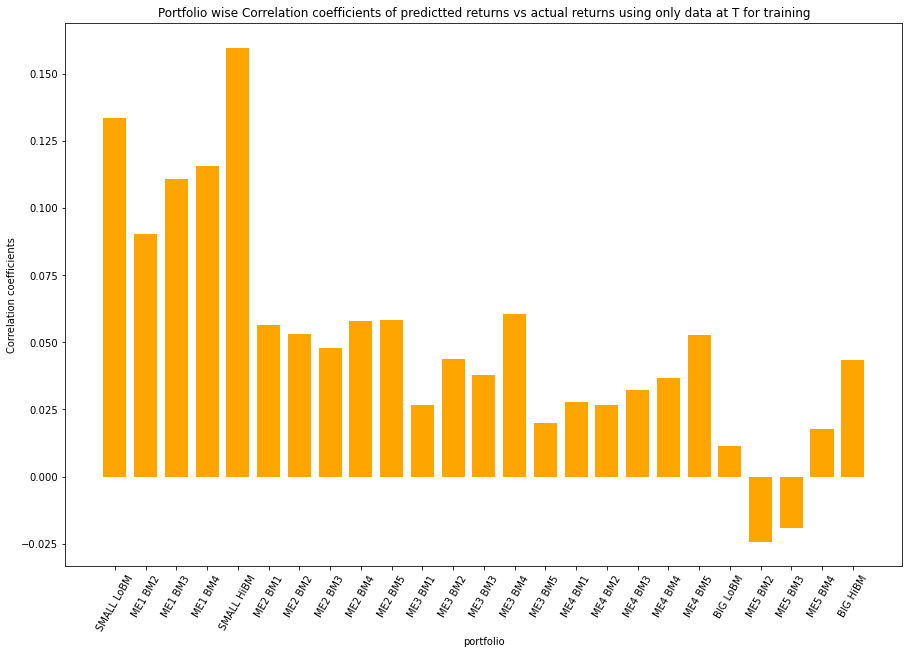

In [190]:
fig, ax = plt.subplots(figsize = (15,10))    
width = 0.75 
plt.grid()
ax.bar(correlation_df.Portfolio,correlation_df.correlation_ActualreturnvsPredictedreturn, width, color="orange")
plt.xticks(rotation = 60)
plt.title('Portfolio wise Correlation coefficients of predictted returns vs actual returns using only data at T for training')
plt.xlabel('portfolio')
plt.ylabel('Correlation coefficients')      
plt.show()

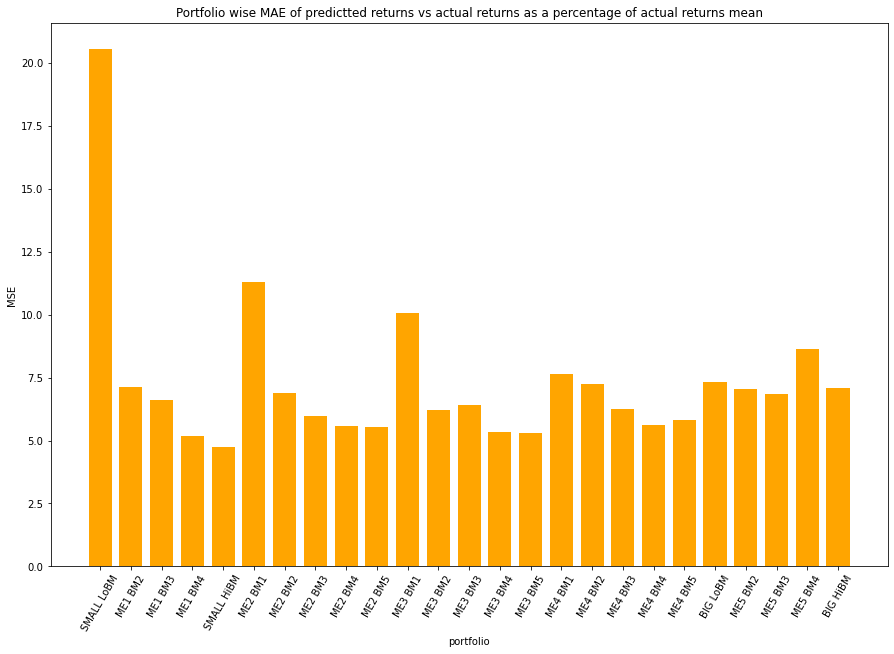

In [191]:
fig, ax = plt.subplots(figsize = (15,10))    
width = 0.75 
plt.grid()
ax.bar(correlation_df.Portfolio,correlation_df.mse, width, color="orange")
plt.xticks(rotation = 60)
plt.title('Portfolio wise MAE of predictted returns vs actual returns as a percentage of actual returns mean')
plt.xlabel('portfolio')
plt.ylabel('MSE')      
plt.show()

### It looks like a decent model since for most assets the prediction error (MAE) is close to 5% of the value

# End of notebook